# Logistic 逻辑回归模型

## 导入必要的库

In [1]:
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, accuracy_score

## 读入数据  代码文件在code文件夹内，预处理后的数据集文件在code文件夹同级的datasets文件夹内

In [2]:
with open('../datasets/train_test_data.pkl', 'rb') as f: 
    X_train, X_test, y_train, y_test = pickle.load(f) 

## 模型代码

In [3]:
class MyLogisticReg:
    """A class for Logistic Regression Models"""
    
    def __init__(self, max_iter=10000, alpha=0.01, C=0.1, epsilon=1e-4, if_pr=True):
        """
        初始化逻辑回归模型
        :param max_iter: 最大迭代次数
        :param alpha: 学习率
        :param C: 正则化参数
        :param epsilon: 收敛阈值
        """
        self.max_iter = max_iter
        self.alpha = alpha
        self.C = C
        self.epsilon = epsilon
        self.Weights = None
        self.cost_history = []
        self.iters = []
        self.timers = []
        self.if_pr = if_pr
    
    def _sigmoid(self, z):
        """
        计算sigmoid函数值
        :param z: 输入值
        :return: sigmoid值
        """
        return 1.0 / (1 + np.exp(-np.clip(z, -500, 500)))  # 防止数值溢出
    
    def _cost(self, weights, x, y):
        """
        计算损失函数值
        :param weights: 权重向量
        :param x: 特征矩阵
        :param y: 标签向量
        :return: 损失值
        """
        eta = x @ weights
        l2_term = 0.5 * self.C * np.sum(np.square(weights[:-1]))  # L2 正则化项，不包含偏置项
        h = self._sigmoid(eta)
        h = np.clip(h, 1e-10, 1 - 1e-10)  # 防止对数计算中的数值不稳定
        cost = -np.sum(y * np.log(h) + (1 - y) * np.log(1 - h)) / x.shape[0] + l2_term
        return cost
    
    def _gradient(self, weights, x, y):
        """
        计算梯度
        :param weights: 权重向量
        :param x: 特征矩阵
        :param y: 标签向量
        :return: 梯度向量
        """
        eta = x @ weights
        h = self._sigmoid(eta)
        h = np.clip(h, 1e-10, 1 - 1e-10)  # 防止对数计算中的数值不稳定
        gradient = (x.T @ (h - y)) / x.shape[0] + self.C * np.vstack((weights[:-1], [0]))
        return gradient
    
    def _gradAscent(self, X_, Y_):
        """
        批量梯度下降法
        :param X_: 特征矩阵
        :param Y_: 标签向量
        """
        t = time.time()
        weights_history = np.zeros([100, self.Weights.shape[0], 1])
        for i in range(self.max_iter):
            diff = np.mean(np.abs(self.Weights - weights_history[i % 100, :]))
            if diff < self.epsilon:
                break
            weights_history[i % 100, :] = self.Weights
            gradient = self._gradient(self.Weights, X_, Y_)
            self.Weights = self.Weights - self.alpha * gradient
            cost = self._cost(self.Weights, X_, Y_)
            if self.if_pr and i % 100 == 0:
                print("L(w, w0) values now: ", cost)
            self.cost_history.append(cost)
            self.iters.append(i)
            self.timers.append(time.time() - t)
        return self.Weights
    
    def _stocGradAscent(self, X_, Y_, batch_size=50):
        """
        随机梯度下降法
        :param X_: 特征矩阵
        :param Y_: 标签向量
        :param batch_size: 批量大小
        """
        t = time.time()
        weights_history = np.zeros([100, self.Weights.shape[0], 1])
        for i in range(self.max_iter):
            random_index = np.random.randint(0, X_.shape[0] - batch_size)
            x = X_[random_index:random_index + batch_size]
            y = Y_[random_index:random_index + batch_size]
            diff = np.mean(np.abs(self.Weights - weights_history[i % 100, :]))
            if diff < self.epsilon:
                break
            weights_history[i % 100, :] = self.Weights
            gradient = self._gradient(self.Weights, x, y)
            self.Weights = self.Weights - self.alpha * gradient
            cost = (self.N / batch_size) * self._cost(self.Weights, x, y)
            if self.if_pr and i % 100 == 0:
                print("L(w, w0) values now: ", cost)
            self.cost_history.append(cost)
            self.iters.append(i)
            self.timers.append(time.time() - t)
        return self.Weights
    
    def fit(self, X, Y, solver="SGD"):
        """
        训练模型
        :param X: 输入特征矩阵
        :param Y: 标签向量
        :param solver: 优化方法，可选 'SGD' 或 'gradient descent'
        """
        X_ = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)
        Y_ = np.reshape(Y, [-1, 1])
        self.N = X_.shape[0]
        self.Weights = np.random.randn(X_.shape[1], 1) * 0.01  # 使用随机初始化
        if solver == "SGD":
            self._stocGradAscent(X_, Y_)
        else:
            self._gradAscent(X_, Y_)
    
    def predict(self, X):
        """
        预测标签
        :param X: 输入特征矩阵
        :return: 预测标签
        """
        X_ = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)
        h = self._sigmoid(X_ @ self.Weights)
        y_pred = (h >= 0.5).astype(int).flatten()
        return y_pred

    def evaluate(self, X, Y):
        """
        评估模型性能
        :param X: 输入特征矩阵
        :param Y: 标签向量
        """
        y_pred = self.predict(X)  # 预测标签
        accuracy = np.mean(y_pred == Y)  # 计算准确率
        tp = np.sum((y_pred == 1) & (Y == 1))  # 真正例
        fp = np.sum((y_pred == 1) & (Y == 0))  # 假正例
        fn = np.sum((y_pred == 0) & (Y == 1))  # 假反例

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # 计算精确率
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # 计算召回率
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # 计算 F1 分数

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")

        # 绘制混淆矩阵
        cm = confusion_matrix(Y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title('Confusion Matrix')
        plt.show()

        # 打印分类报告
        print("\nClassification Report:")
        print(classification_report(Y, y_pred))

        # 绘制 ROC 曲线
        y_pred_prob = self.predict_proba(X)
        fpr, tpr, thresholds = roc_curve(Y, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()

    def predict_proba(self, X):
        """
        预测概率
        :param X: 输入特征矩阵
        :return: 预测概率
        """
        X_ = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)
        h = self._sigmoid(X_ @ self.Weights)
        return h.flatten()

## 训练评估模型

In [4]:
# 对特征进行标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

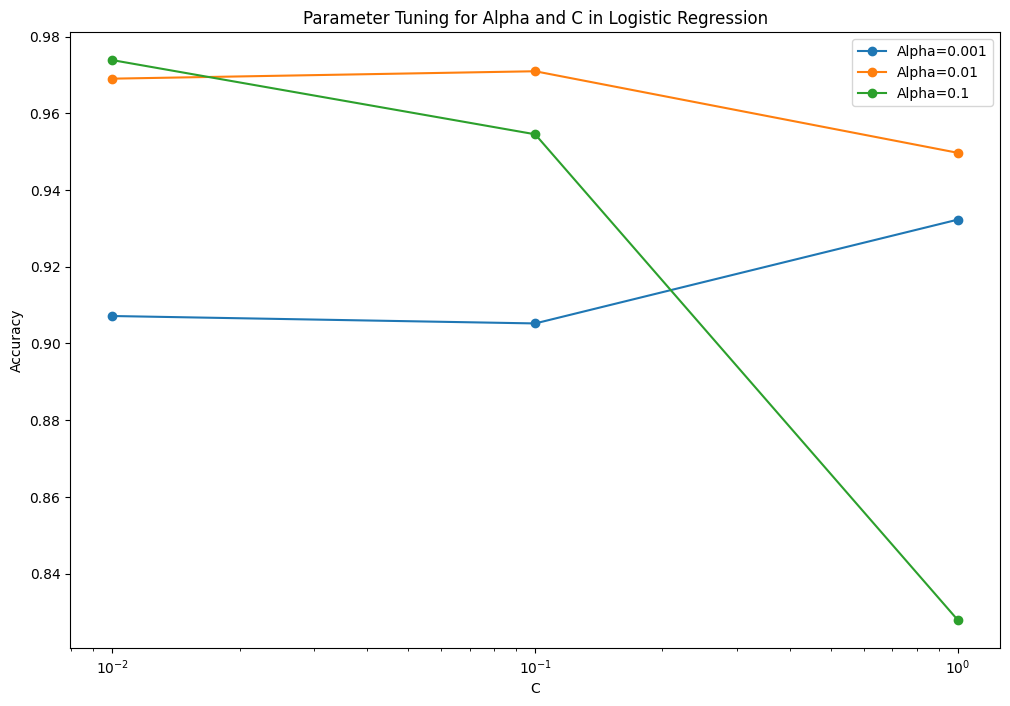

In [5]:
# 定义参数网格
alphas = [0.001, 0.01, 0.1]
Cs = [0.01, 0.1, 1]

# 存储结果
results = []

# 训练模型并记录结果
for alpha in alphas:
    for C in Cs:
        # 初始化模型
        regr = MyLogisticReg(max_iter=1000, alpha=alpha, C=C, epsilon=1e-4, if_pr=False)
        
        # 训练模型
        regr.fit(X_train_scaled, y_train, solver="SGD")
        
        # 预测
        y_pred = regr.predict(X_test_scaled)
        
        # 记录准确率
        acc = accuracy_score(y_test, y_pred)
        results.append((alpha, C, acc))

# 转换为DataFrame以便绘图
results_df = pd.DataFrame(results, columns=['alpha', 'C', 'accuracy'])

# 绘制调优曲线
plt.figure(figsize=(12, 8))

# 绘制不同alpha下的C值调优曲线
for alpha in alphas:
    subset = results_df[results_df['alpha'] == alpha]
    plt.plot(subset['C'], subset['accuracy'], marker='o', label=f'Alpha={alpha}')

plt.xscale('log')  # 因为C值是对数分布的，所以x轴也设置为对数刻度
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Parameter Tuning for Alpha and C in Logistic Regression')
plt.legend()
plt.show()

### 1、批量梯度下降（Gradient Descent, GD）
批量梯度下降是经典的优化算法，它使用整个训练数据集来计算每次迭代的梯度。具体来说：

工作原理：在每次迭代中，计算所有训练样本的梯度，然后用这个梯度来更新模型的权重。
优点：
收敛稳定，因为每次更新都是基于所有数据的平均梯度。
理论上可以找到全局最优解（对于凸优化问题）。
缺点：
计算成本高，特别是当数据集很大时，每次迭代都需要遍历所有样本。
计算速度慢，不适合大规模数据集。

In [6]:
# 初始化模型
regr1 = MyLogisticReg(max_iter=10000, alpha=0.01, C=0.1, epsilon=1e-4)

# 训练模型
regr1.fit(X_train_scaled, y_train, solver="GD")

L(w, w0) values now:  0.7193878634421
L(w, w0) values now:  0.40164954632422756
L(w, w0) values now:  0.3146799319170717
L(w, w0) values now:  0.27798679290790734
L(w, w0) values now:  0.2601860378452171
L(w, w0) values now:  0.2508173763272523
L(w, w0) values now:  0.24560094069077773
L(w, w0) values now:  0.2425680740728056
L(w, w0) values now:  0.24074015405086013
L(w, w0) values now:  0.23960292727426177
L(w, w0) values now:  0.2388745189341176
L(w, w0) values now:  0.2383951040423013
L(w, w0) values now:  0.23807142040683313
L(w, w0) values now:  0.23784763434334855
L(w, w0) values now:  0.23768951172879627
L(w, w0) values now:  0.23757557418692019
L(w, w0) values now:  0.2374920393502543


Accuracy: 0.9729
Precision: 0.8767
Recall: 0.9275
F1 Score: 0.9014


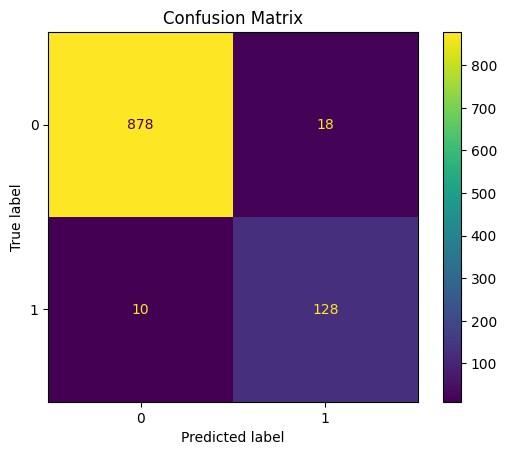


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       896
           1       0.88      0.93      0.90       138

    accuracy                           0.97      1034
   macro avg       0.93      0.95      0.94      1034
weighted avg       0.97      0.97      0.97      1034



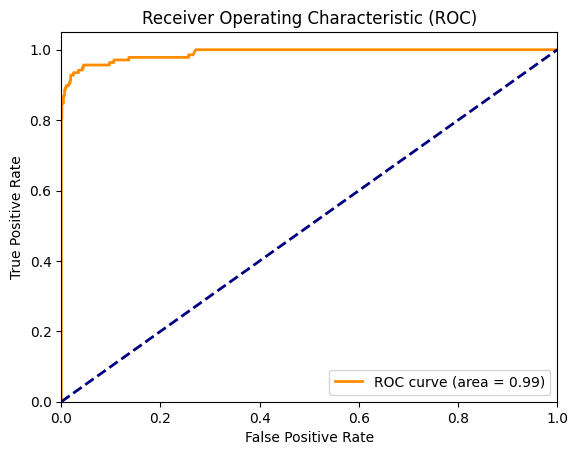

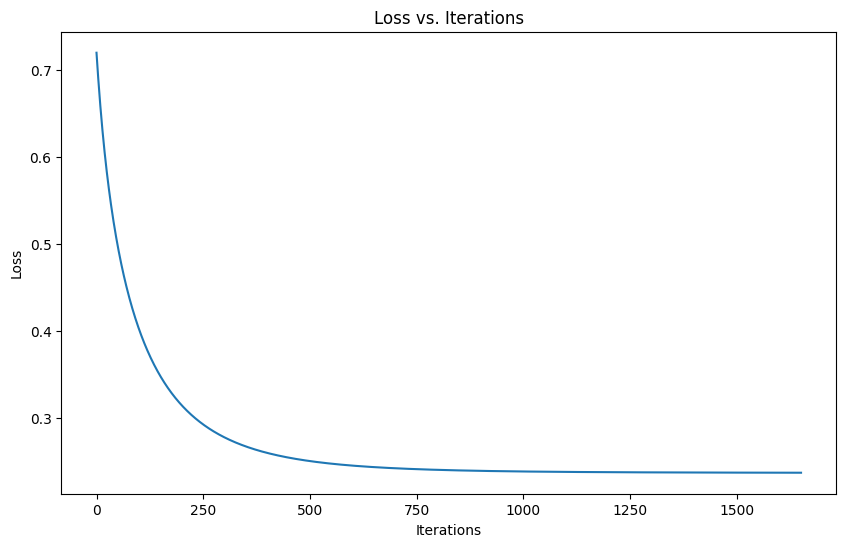

In [7]:
# 评估模型
regr1.evaluate(X_test_scaled, y_test)


# 绘制损失函数曲线
plt.figure(figsize=(10, 6))
plt.plot(regr1.iters, regr1.cost_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.show()

### 2、随机梯度下降（Stochastic Gradient Descent, SGD）
随机梯度下降是一种改进的优化算法，它每次只使用一个或一小部分训练样本（批次）来计算梯度并更新权重。具体来说：

工作原理：在每次迭代中，随机选择一个小批量（batch）的数据来计算梯度，并用这个梯度来更新模型的权重。
优点：
计算速度快，每次迭代只需要处理一小部分数据。
可以更快地逃离局部极小值，有助于找到更好的解。
适用于大规模数据集。
缺点：
更新不稳定，因为每次迭代的梯度波动较大。
可能需要更多的迭代次数才能收敛。

In [8]:
# 初始化模型
regr2 = MyLogisticReg(max_iter=10000, alpha=0.01, C=0.1, epsilon=1e-4)

regr2.fit(X_train_scaled, y_train, solver="SGD")

L(w, w0) values now:  48.500342595534384
L(w, w0) values now:  26.829214947867154
L(w, w0) values now:  22.903035152273425
L(w, w0) values now:  17.00406736672891
L(w, w0) values now:  24.72229604253604
L(w, w0) values now:  20.64556219178988
L(w, w0) values now:  18.86743570591363
L(w, w0) values now:  18.185762715514752
L(w, w0) values now:  19.81689669303967
L(w, w0) values now:  18.020488006411526
L(w, w0) values now:  18.57544415630362
L(w, w0) values now:  19.342644088777995
L(w, w0) values now:  20.944555406669448
L(w, w0) values now:  23.73985743633356
L(w, w0) values now:  17.783579424881584
L(w, w0) values now:  18.887036098941202
L(w, w0) values now:  18.401392249197794
L(w, w0) values now:  17.37206597126752
L(w, w0) values now:  19.178180988560346
L(w, w0) values now:  19.200225339041925
L(w, w0) values now:  21.183912611906283
L(w, w0) values now:  17.59834289283875
L(w, w0) values now:  18.953381826531373
L(w, w0) values now:  19.34696602195035
L(w, w0) values now:  20.5

Accuracy: 0.9691
Precision: 0.8581
Recall: 0.9203
F1 Score: 0.8881


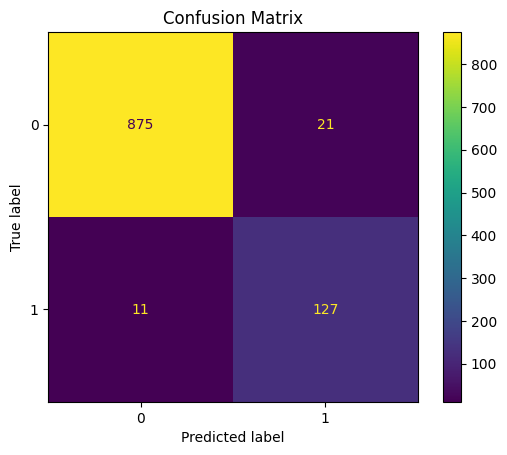


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       896
           1       0.86      0.92      0.89       138

    accuracy                           0.97      1034
   macro avg       0.92      0.95      0.94      1034
weighted avg       0.97      0.97      0.97      1034



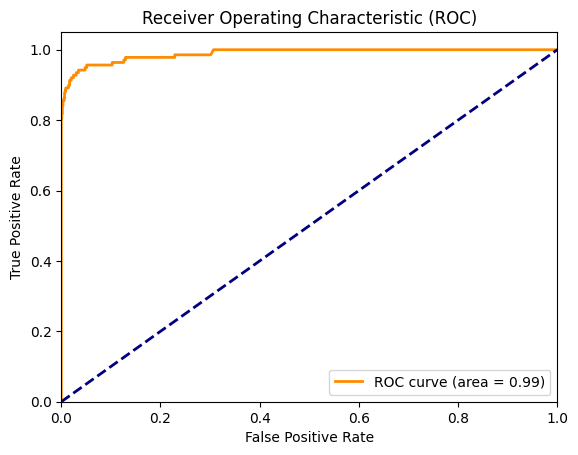

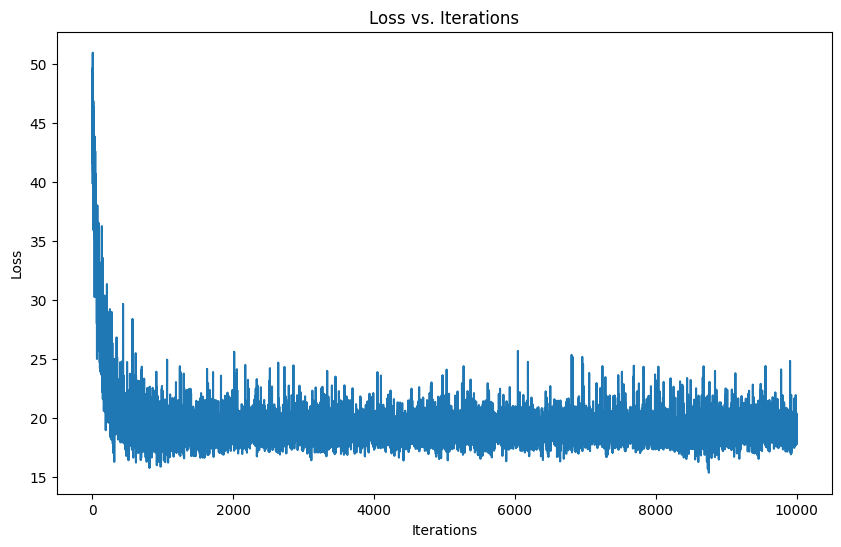

In [9]:
# 评估模型
regr2.evaluate(X_test_scaled, y_test)


# 绘制损失函数曲线
plt.figure(figsize=(10, 6))
plt.plot(regr2.iters, regr2.cost_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.show()